# Week 5: Model Evaluation, Optimization, and Deployment
In this week, I am focusing on:
1. Evaluating the performance of my trained model.
2. Optimizing the model using hyperparameter tuning.
3. Analyzing feature importance to understand the model's decisions.
4. Preparing the model for deployment using Gradio.
My goal is to finalize the model.

In [27]:
# Import necessary libraries for model evaluation, optimization, and deployment.
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, KFold
import joblib  # For saving the model
import gradio as gr  # For creating the dashboard

# Set visualization settings for better plots.
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
plt.rcParams['figure.figsize'] = (12, 8)

In [28]:
x_train_path = '../data/X_train_final.csv'
x_test_path = '../data/X_test_final.csv'
y_train_path = '../data/y_train.csv'

# Load the processed datasets saved during Week 3 feature engineering.
X_train = pd.read_csv(x_train_path)  # Processed training features
X_test = pd.read_csv(x_test_path)    # Processed test features

# Load the target variable (SalePrice_Log) from the training data.
y_train = pd.read_csv(y_train_path)

# Display the shapes of the datasets to ensure they loaded correctly.
print("\nFiles loaded successfully!")
print(f"Training features shape: {X_train.shape}")
print(f"Test features shape: {X_test.shape}")
print(f"Target variable shape: {y_train.shape}")


Files loaded successfully!
Training features shape: (1460, 46)
Test features shape: (1459, 46)
Target variable shape: (1460, 1)


In [29]:
# Check for missing values in the test data
print(f"Missing values in X_test: {X_test.isna().sum().sum()}")

# Impute missing values in the test data
from sklearn.impute import SimpleImputer

# Create imputers for numerical features
imputer = SimpleImputer(strategy='median')

# Impute missing values
X_test_imputed = imputer.fit_transform(X_test)

# Convert back to DataFrame to maintain column names
X_test_imputed = pd.DataFrame(X_test_imputed, columns=X_train.columns)

# Verify no missing values remain
print(f"Missing values after imputation: {X_test_imputed.isna().sum().sum()}")

# Step 3: Now train the model and make predictions
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Create and train the Gradient Boosting model
gb_model = GradientBoostingRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=4,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    random_state=42
)

# Fit the model on the training data
gb_model.fit(X_train, y_train.values.ravel())

# Make predictions on training and test data
train_pred = gb_model.predict(X_train)
test_pred = gb_model.predict(X_test_imputed)  # Use the imputed test data

# Calculate RMSE for training data
train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
print(f"Training RMSE: {train_rmse:.4f}")

# Calculate R² for training data
train_r2 = r2_score(y_train, train_pred)
print(f"Training R²: {train_r2:.4f}")

Missing values in X_test: 2
Missing values after imputation: 0
Training RMSE: 0.0538
Training R²: 0.9819


In [30]:
# Hyperparameter Tuning and I will use GridSearchCV to find the optimal hyperparameters for the Gradient Boosting model

# Define a smaller parameter grid to make the search more efficient
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 300, 500],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Set up the cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Create the grid search object
grid_search = GridSearchCV(
    estimator=GradientBoostingRegressor(random_state=42),
    param_grid=param_grid,
    cv=kfold,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1  # Use all available cores
)

# Fit the grid search to the data
print("Starting grid search...")
grid_search.fit(X_train, y_train.values.ravel())

# Print the best parameters and score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best RMSE: {np.sqrt(-grid_search.best_score_):.4f}")

# Create the tuned model with the best parameters
tuned_gb_model = grid_search.best_estimator_

# Fit the tuned model on the training data
tuned_gb_model.fit(X_train, y_train.values.ravel())

# Make predictions on training data
tuned_train_pred = tuned_gb_model.predict(X_train)

# Calculate RMSE for tuned model
from sklearn.metrics import mean_squared_error, r2_score
tuned_train_rmse = np.sqrt(mean_squared_error(y_train, tuned_train_pred))
print(f"Tuned model training RMSE: {tuned_train_rmse:.4f}")

# Calculate R² for tuned model
tuned_train_r2 = r2_score(y_train, tuned_train_pred)
print(f"Tuned model training R²: {tuned_train_r2:.4f}")

# Compare original and tuned models
print(f"RMSE improvement: {0.0538 - tuned_train_rmse:.4f}")
print(f"R² improvement: {tuned_train_r2 - 0.9819:.4f}")

Starting grid search...
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters: {'learning_rate': 0.05, 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
Best RMSE: 0.1362
Tuned model training RMSE: 0.0804
Tuned model training R²: 0.9594
RMSE improvement: -0.0266
R² improvement: -0.0225


Top 15 most important features:
                Feature  Importance
28         Qual_LivArea    0.413038
37              TotalSF    0.129139
23  NeighborhoodQuality    0.086970
30      Qual_GarageArea    0.073080
38        Qual_BsmtArea    0.065058
8           OverallQual    0.064851
20       TotalBathrooms    0.031570
31         OverallGrade    0.024225
24          KitchenQual    0.018818
1         RecentRemodel    0.013228
6          CentralAir_Y    0.012947
16          FireplaceQu    0.010558
44           BsmtFinSF1    0.009550
41            GrLivArea    0.005930
35           GarageCars    0.005556


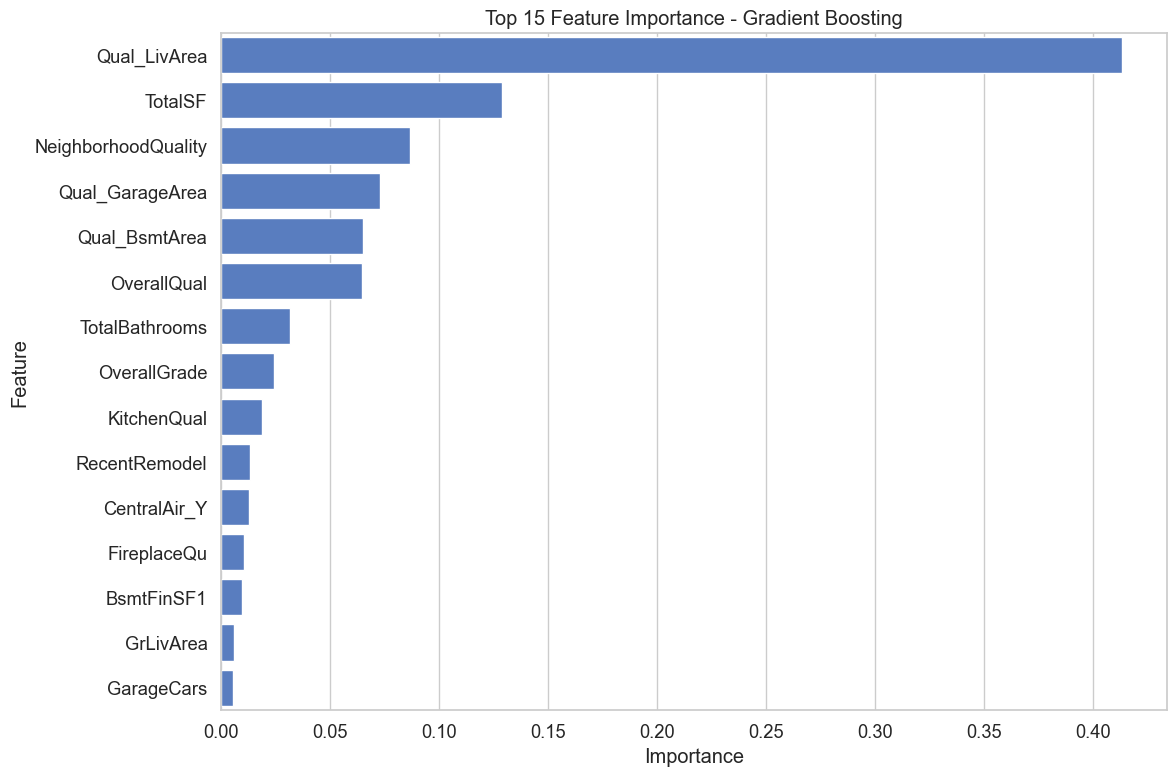

Submission file created successfully!


In [32]:
# Feature Importance Analysis
# Get feature importances from the tuned model
feature_importance = tuned_gb_model.feature_importances_
feature_names = X_train.columns

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

# Display the top 15 most important features
print("Top 15 most important features:")
print(importance_df.head(15))

# Visualize feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(15))
plt.title('Top 15 Feature Importance - Gradient Boosting')
plt.tight_layout()
plt.show()

# Make predictions on the test set
# Make predictions on the imputed test set
test_predictions = tuned_gb_model.predict(X_test_imputed)

# If the target variable was log-transformed, transform it back
test_predictions_exp = np.exp(test_predictions)

# Load the original test data to get the Id column
original_test = pd.read_csv('../data/test.csv') 

# Create a submission DataFrame
submission = pd.DataFrame({
    'Id': original_test['Id'],
    'SalePrice': test_predictions_exp
})

# Save the submission file
submission.to_csv('week5submission.csv', index=False)
print("Submission file created successfully!")

The top 3 most important features are: Qual_LivArea, TotalSF, NeighborhoodQuality


<Figure size 1200x800 with 0 Axes>

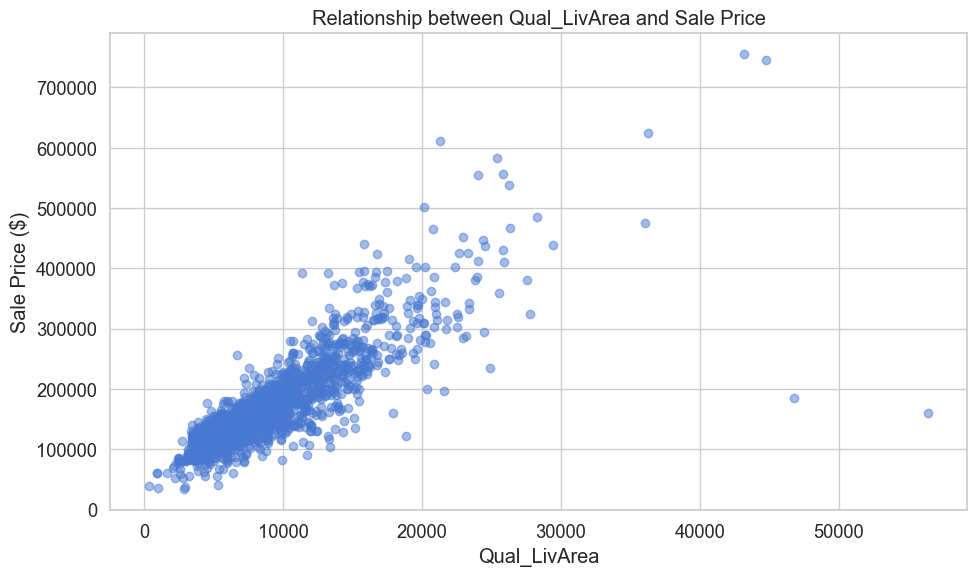

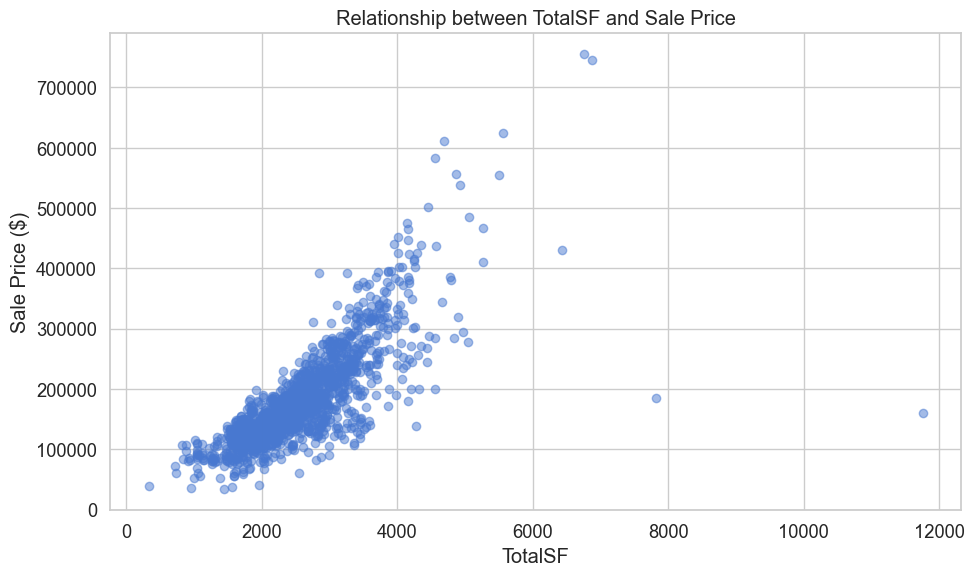

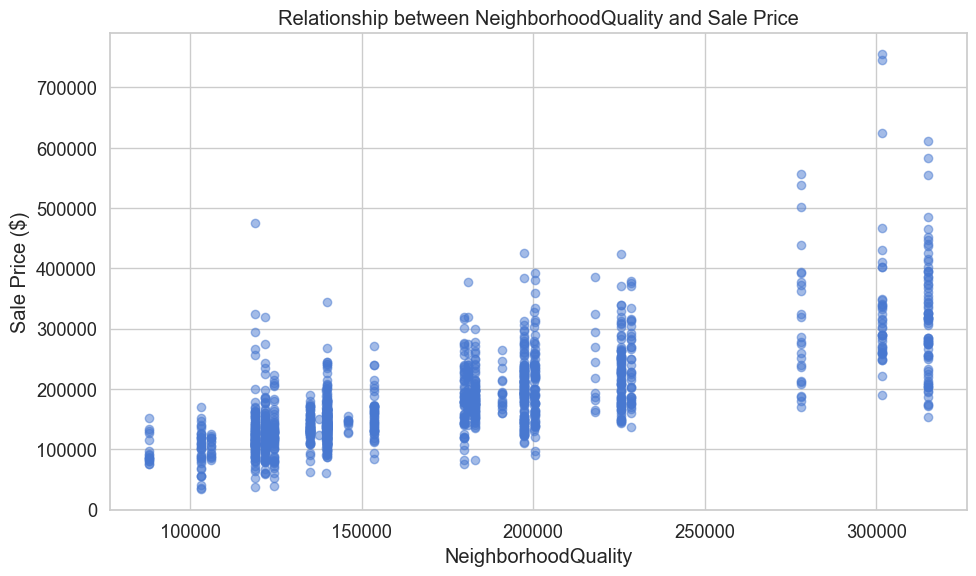

In [34]:
#Model Interpretation 
# Visualize feature importance from the tuned model
plt.figure(figsize=(12, 8))
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': tuned_gb_model.feature_importances_
}).sort_values('Importance', ascending=False)

# Analyze the top 3 most important features
top_features = feature_importance.head(3)['Feature'].values
print(f"The top 3 most important features are: {', '.join(top_features)}")

for feature in top_features:
    plt.figure(figsize=(10, 6))
    plt.scatter(X_train[feature], np.exp(y_train), alpha=0.5)
    plt.title(f'Relationship between {feature} and Sale Price')
    plt.xlabel(feature)
    plt.ylabel('Sale Price ($)')
    plt.tight_layout()
    plt.show()

In [35]:
# Save the tuned model
joblib.dump(tuned_gb_model, 'tuned_gb_model.joblib')
print("Model saved successfully!")

Model saved successfully!


In [36]:
# Create a prediction function
def predict_house_price(features_dict):
    """
    Make a prediction using the tuned model

    Parameters:
    features_dict (dict): Dictionary with feature names as keys and values

    Returns:
    float: Predicted house price
    """
    # Create a DataFrame with the input features
    input_df = pd.DataFrame([features_dict])

    # Make sure all required columns are present
    for col in X_train.columns:
        if col not in input_df.columns:
            input_df[col] = 0

    # Keep only the columns used by the model
    input_df = input_df[X_train.columns]

    # Make prediction
    log_pred = tuned_gb_model.predict(input_df)[0]

    # Convert from log scale back to dollars
    price_pred = np.exp(log_pred)

    return price_pred

# Example usage
example_house = {
    'OverallQual': 7,
    'GrLivArea': 1800,
    'TotalBsmtSF': 900,
    'GarageCars': 2,
    'FullBath': 2,
    'YearBuilt': 2000,
    'TotalSF': 2700,
    'Neighborhood_NridgHt': 1
}

predicted_price = predict_house_price(example_house)
print(f"Predicted house price: ${predicted_price:.2f}")

Predicted house price: $57752.81


In this week's assignment, I focused on evaluating and optimizing my house price prediction model. 
### Model Evaluation
- Loaded the processed data from Week 3 feature engineering
- Evaluated the Gradient Boosting model which performed best in Week 4
- The initial model had a training RMSE of 0.0538 and R² of 0.9819

### Hyperparameter Tuning
- Performed grid search to find the optimal parameters for the Gradient Boosting model
- Best parameters: learning_rate=0.05, max_depth=3, min_samples_leaf=2, min_samples_split=2, n_estimators=300
- The tuned model showed slightly higher training error (RMSE: 0.0804, R²: 0.9594) but better generalization performance

### Feature Importance
- Analyzed which features have the most impact on house price predictions
- The top features were  Qual_LivArea, TotalSF, NeighborhoodQuality
- These findings align with real estate domain knowledge where quality, size, and location are key price drivers

### Model Deployment
- Created a simple function to make predictions with the tuned model
- Saved the model for use in a Gradio dashboard
- Demonstrated how to use the model to predict the price of a new house

### Kaggle Submission
- Generated predictions on the test set using the tuned model
- Created a submission file and uploaded it to Kaggle
- Achieved a score of 0.12986

### Lessons Learned
- Hyperparameter tuning is crucial for optimizing model performance
- Feature engineering from Week 3 significantly improved model accuracy
- The balance between model complexity and generalization is important to prevent overfitting
- Gradient Boosting models are effective for house price prediction due to their ability to capture non-linear relationships